# 07. PyTorch Experiment Tracking

Machine Learning is very experimental

In order to figure out which experminets are worth pursuing, that's where **experiment tracking** comes in, it helps you to figure out what doesn't work so you can figure out what does work

In this notebook, we're going to see an example of programmatically tracking experiments

## Resources

**Course book:** https://www.learnpytorch.io/07_pytorch_experiment_tracking/

## 0. Prepare libraries

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.7.1+cu126
0.22.1+cu126


In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary

from src import get_data, setup_data, engine

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)

device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random seeds for torch operations

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    
    # Set the see for general torch operations
    torch.manual_seed(seed)
    
    # Set the seed for CUDA torch operations
    torch.cuda.manual_seed(seed)
    
    # Set the seed for MPS torch operations
    torch.mps.manual_seed(seed)

## 1. Get data

Want to get pizza, steak, sushi images.

So we can run epxeriments buidling FoodVision Mini and see which model performs best

In [5]:
get_data.get_data(
    data_dir_str="data/",
    image_path_str="pizza_steak_sushi",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    file_name_str="pizza_steak_sushi.zip"
)

data/pizza_steak_sushi does not exists, creating...
Extracting pizza_steak_sushi.zip...
Deleting pizza_steak_sushi.zip...
Finished getting data...


## 2. Create DataSets and DataLoaders

### 2.1 Creating DataLoaders with manual transforms

The goal with transforms is to ensure your cusotm data is formatted in a reproducible way as well as a way thta will suit pretrained models

In [6]:
# Setup direcotires
from pathlib import Path

image_path = Path("data/pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
# Setup ImageNet normalization levels
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

print(f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32,
    num_workers=1,
)

print(f"Size of train_dataloader: {len(train_dataloader)} | Size of test_dataloader {len(test_dataloader)}")
print(f"Class names: {class_names}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Size of train_dataloader: 8 | Size of test_dataloader 3
Class names: ['pizza', 'steak', 'sushi']


### 2.2 Create DataLoader using automatically created transforms

The same principle applies for automatic transforms: we want our custom data in the same format as a pretrained model was trained on

In [8]:
# Setup directories
from pathlib import Path

image_path = Path("data/pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [9]:
# Setup pretrained weights (plenty of these weights available in torchvision.models)
from torchvision import models

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # best available

# Get transforms from weights (these are the transforms used to train a particualr or obtained particular set of weights)
automatic_transforms = weights.transforms()

print(f"Automatically created transforms: {automatic_transforms}")

# Create DataLoaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32,
    num_workers=1,
)

print(f"Size of train_dataloader: {len(train_dataloader)} | Size of test_dataloader {len(test_dataloader)}")
print(f"Class names: {class_names}")

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Size of train_dataloader: 8 | Size of test_dataloader 3
Class names: ['pizza', 'steak', 'sushi']


## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [10]:
# Old way
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/michal-chojna/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/home/michal-chojna/Desktop/Repos/pytorch-course/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/pytorch-course/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:01<00:00, 10.9MB/s]


In [11]:
# New way
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with pretrained weights and send it to the target model
model = torchvision.models.efficientnet_b0(
    weights=weights
).to(device)

In [12]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Change classifier head
set_seeds()
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
from torchinfo import summary
summary(
    model=model,
    input_size=(1, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train a single model and track results

In [15]:
# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

In [16]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [17]:
from src.engine import train_step, test_step
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(
    model: torch.nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    test_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Args:
        model (torch.nn.Module): A PyTorch model to be trained
            and tested.
        train_dataloader (torch.utils.data.DataLoader): A DataLoader
            instance for the model to be trained on.
        test_dataloader (torch.utils.data.DataLoader): A DataLoader
            instance for the model to be tested on.
        optimizer (torch.optim.Optimizer): A PyTorch optimizer to
            help minimize the loss function.
        loss_fn (torch.nn.Module): A PyTorch loss function to
            calculate loss on both datasets.
        epochs (int): An integer indicating how many epochs
            to train for.
        device (torch.device): A target device to compute
            on (e.g. "cuda" or "cpu").

    Returns:
        Dict[str, List[float]]: A dictionary of training and
        testing loss as well as training and
        testing accuracy metrics. Each metric has a value in
        a list for each epoch.
    """
    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### New: Experiment tracking ###
        
        writer.add_scalars(
            main_tag="Loss",
            tag_scalar_dict={
                "train_loss": train_loss,
                "test_loss": test_loss
            },
            global_step=epoch
        )
        
        writer.add_scalars(
            main_tag="Accuracy",
            tag_scalar_dict={
                "train_acc": train_acc,
                "test_acc": test_acc
            },
            global_step=epoch
        )
        writer.add_graph(
            model=model,
            input_to_model=torch.randn(32, 3, 224, 224).to(device),
        )
        
    # Close the writer
    writer.close()
    
    ### End new ###
        
    # Return the filled results at the end of the epochs
    return results

In [19]:
# Train model
set_seeds()

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8975 | train_acc: 0.6562 | test_loss: 0.7837 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8038 | train_acc: 0.7461 | test_loss: 0.6723 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6769 | train_acc: 0.8516 | test_loss: 0.6698 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7065 | train_acc: 0.7188 | test_loss: 0.6746 | test_acc: 0.7737


In [20]:
results

{'train_loss': [1.0923909693956375,
  0.8974810466170311,
  0.8037681579589844,
  0.6769492998719215,
  0.7065149024128914],
 'train_acc': [0.3984375, 0.65625, 0.74609375, 0.8515625, 0.71875],
 'test_loss': [0.9132636189460754,
  0.7837291161219279,
  0.6722716887791952,
  0.669819712638855,
  0.674595296382904],
 'test_acc': [0.5397727272727273,
  0.8560606060606061,
  0.8863636363636364,
  0.8049242424242425,
  0.7736742424242425]}

## 5. View our model's results with TensorBoard

There are a fwe ways to view TensorBoard results

In [22]:
# Let's view our experiments from withing the notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17314), started 0:00:34 ago. (Use '!kill 17314' to kill it.)

## 6. Create a functino to prepare a `SummaryWriter()` instance

By default our `SummaryWriter()` class saves to `log_dir` parameter

How about if we wanted to save different experiments to different folders

In essence, one experiment = one folder

For example, we'd like to track
* Experiment date/timestamp
* Experiment name
* Model name
* Extra - is there anything else that should be tracker?

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account.

So ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [23]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(
    experiment_name: str,
    model_name: str,
    extra: str = None
):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
    
    from datetime import datetime
    import os
    
    # Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")


    return SummaryWriter(log_dir=log_dir)

In [24]:
example_writer = create_writer(
    experiment_name="data_10_percent",
    model_name="effnetb0",
    extra="5_epochs"
)
example_writer

[INFO] Created SummaryWriter saving to runs/2025-08-18/data_10_percent/effnetb0/5_epochs


### 6.1 Update `train()` function to include `writer` parameter

In [25]:
from src.engine import train_step, test_step
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(
    model: torch.nn.Module, 
    train_dataloader: torch.utils.data.DataLoader, 
    test_dataloader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
    writer: torch.utils.tensorboard.writer.SummaryWriter = None
) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Args:
        model (torch.nn.Module): A PyTorch model to be trained
            and tested.
        train_dataloader (torch.utils.data.DataLoader): A DataLoader
            instance for the model to be trained on.
        test_dataloader (torch.utils.data.DataLoader): A DataLoader
            instance for the model to be tested on.
        optimizer (torch.optim.Optimizer): A PyTorch optimizer to
            help minimize the loss function.
        loss_fn (torch.nn.Module): A PyTorch loss function to
            calculate loss on both datasets.
        epochs (int): An integer indicating how many epochs
            to train for.
        device (torch.device): A target device to compute
            on (e.g. "cuda" or "cpu").

    Returns:
        Dict[str, List[float]]: A dictionary of training and
        testing loss as well as training and
        testing accuracy metrics. Each metric has a value in
        a list for each epoch.
    """
    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### New: Experiment tracking ###
        if writer:
        
            writer.add_scalars(
                main_tag="Loss",
                tag_scalar_dict={
                    "train_loss": train_loss,
                    "test_loss": test_loss
                },
                global_step=epoch
            )
            
            writer.add_scalars(
                main_tag="Accuracy",
                tag_scalar_dict={
                    "train_acc": train_acc,
                    "test_acc": test_acc
                },
                global_step=epoch
            )
            writer.add_graph(
                model=model,
                input_to_model=torch.randn(32, 3, 224, 224).to(device),
            )
            
            # Close the writer
            writer.close()
        else:
            pass
    
    ### End new ###
        
    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

* Setup 2x modeling experiments with effnetb0, pizza, steak, sushi data and one model for 5 epochs and another model for 10 epochs

### 7.1 What kind of experiments should you rum?

Tje number of machine learning experiments you can run, is like the number of different models you can build... almost limitless

However, you can't test everything...

So what should you test?
* Change the number of epochs
* Change the number of hidden layers / units
* Change the amount of data (right now we're using 10% of the Food101 dataset for pizza, steak, sushi)
* Change the learning rate
* Try different kinds of data augmentation
* Choose a different model architecture

This is why transfer learning is so powerful, because it's a working model you can apply to your own problem

### 7.2 What experiments are we going to run?

We're going to turn three dials:
1. Model size - EffNetB0 vs EffNetB2 (in terms of number of parameters)
2. Dataset size - 10% of pizza, steak, sushi images vs 20% (generally mode data = better results)
3. Training time - 5 epochs vs 10 epochs (generally longer training time = better reults, up to a point)

To begin, we're sill keeping things relatively small so that our experiment run quickly

Our goal: a model that is well performing but sill small enougth to run on a mobile device or web browser, so FoodVision Mini can come to life

If you had infinite computer + time, you should basically always choose the biggest model and the biggest dataset you can, see: https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf

### 7.3 Download different datasets

We want two datasets:
1. Pizza, steak, sushi 10%
2. Pizza, steak, sushi 20%

In [26]:
from src import get_data

get_data.get_data(
    data_dir_str="data/",
    image_path_str="pizza_steak_sushi_10",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    file_name_str="pizza_steak_sushi.zip",
)

data/pizza_steak_sushi_10 does not exists, creating...
Extracting pizza_steak_sushi.zip...
Deleting pizza_steak_sushi.zip...
Finished getting data...


In [27]:
get_data.get_data(
    data_dir_str="data/",
    image_path_str="pizza_steak_sushi_20",
    data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    file_name_str="pizza_steak_sushi_20_percent.zip",
)

data/pizza_steak_sushi_20 does not exists, creating...
Extracting pizza_steak_sushi_20_percent.zip...
Deleting pizza_steak_sushi_20_percent.zip...
Finished getting data...


### 7.4 Transforms Datasets and create DataLoaders

We'll to transform our data in a few ways:

1. Resize the images to (224, 224)
2. Make sure image tensor values are between [0, 1]
3. Normalize the images so they have the same data distribution as ImageNet

In [28]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [29]:
from src import setup_data

train_dataloader_10, test_dataloader_10, class_names_10 = setup_data.create_dataloaders(
    train_dir="data/pizza_steak_sushi_10/train",
    test_dir="data/pizza_steak_sushi_10/test",
    transform=simple_transform,
    batch_size=32,
    num_workers=1
)

len(train_dataloader_10), len(test_dataloader_10), class_names_10

(8, 3, ['pizza', 'steak', 'sushi'])

In [30]:
train_dataloader_20, test_dataloader_20, class_names_20 = setup_data.create_dataloaders(
    train_dir="data/pizza_steak_sushi_20/train",
    test_dir="data/pizza_steak_sushi_20/test",
    transform=simple_transform,
    batch_size=32,
    num_workers=1
)

len(train_dataloader_20), len(test_dataloader_20), class_names_20

(15, 5, ['pizza', 'steak', 'sushi'])

### 7.5 Create feature extractor models

We want two functions
1. Create a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layer and a custom classifier head
2. Create a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layer and a custom classifier head

In [31]:
OUT_FEATURE = len(class_names)

# Create and EffNetB0 feature extractor
def create_effnetb0() -> torch.nn.Module:
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # Freeze the base model layers
    for param in model.parameters():
        param.requires_grad = False
        
    # Change the classifier head
    set_seeds()
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=1280, out_features=OUT_FEATURE)
    ).to(device)
    
    # Give the model a name
    model.name = "effnetb0"
    
    print(f"[INFO] Create new {model.name} model...")
    
    return model

In [34]:
OUT_FEATURE = len(class_names)

# Create and EffNetB0 feature extractor
def create_effnetb2() -> torch.nn.Module:
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    # Freeze the base model layers
    for param in model.parameters():
        param.requires_grad = False
        
    # Change the classifier head
    set_seeds()
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.3, inplace=True),
        torch.nn.Linear(in_features=1408, out_features=OUT_FEATURE)
    ).to(device)
    
    # Give the model a name
    model.name = "effnetb2"
    
    print(f"[INFO] Created new {model.name} model...")
    
    return model

In [35]:
test_effnetb0 = create_effnetb0()
test_effnetb2 = create_effnetb2()

[INFO] Create new effnetb0 model...
[INFO] Created new effnetb2 model...


In [36]:
summary(test_effnetb0)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 (864)
│    │    └─BatchNorm2d: 3-2                            (64)
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 (1,448)
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 (6,004)
│    │    └─MBConv: 3-6                                 (10,710)
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 (15,350)
│    │    └─MBConv: 3-8                                 (31,290)
│    └─Sequential: 2-5                                  --
│    │    └─MBConv

In [37]:
summary(test_effnetb2)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 (864)
│    │    └─BatchNorm2d: 3-2                            (64)
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 (1,448)
│    │    └─MBConv: 3-5                                 (612)
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-6                                 (6,004)
│    │    └─MBConv: 3-7                                 (10,710)
│    │    └─MBConv: 3-8                                 (10,710)
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-9                                 (16,518)
│    │    └─MBC

### 7.6 Create experiments and set up training code

In [38]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# Create a DataLoaders dictionary
train_dataloaders = {
    "data_10_percent": train_dataloader_10,
    "data_20_percent": train_dataloader_20,
}

In [41]:
%%time
from src import utils

# Set seeds
set_seeds()

# Keep track of experiment numberes
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:
            
            # Print out info
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")
            
            # Select and create model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
                
            # Create a new loss and optimizer for every model
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(
                params=model.parameters(),
                lr=0.001,
            )
            
            # Train target model with target dataloader and track experiments
            train(
                model=model, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader, 
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer=create_writer(
                    experiment_name=dataloader_name,
                    model_name=model.name,
                    extra=f"{epochs}_epochs"
                )
            )
            
            # Save model to file so we can import it later if need be
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            utils.save_model(
                model=model,
                target_dir="models",
                model_name=save_filepath
            )
            
            print("\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2025-08-18/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.8976 | test_acc: 0.6004
Epoch: 2 | train_loss: 0.9399 | train_acc: 0.5391 | test_loss: 0.8332 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7355 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7012 | train_acc: 0.7773 | test_loss: 0.6412 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6140 | train_acc: 0.8867 | test_loss: 0.6120 | test_acc: 0.9062
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth


[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2025-08-18/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0869 | train_acc: 0.3984 | test_loss: 0.9646 | test_acc: 0.6402
Epoch: 2 | train_loss: 0.8947 | train_acc: 0.6328 | test_loss: 0.9017 | test_acc: 0.6733
Epoch: 3 | train_loss: 0.8469 | train_acc: 0.6680 | test_loss: 0.8133 | test_acc: 0.7955
Epoch: 4 | train_loss: 0.7031 | train_acc: 0.8516 | test_loss: 0.7063 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.7012 | train_acc: 0.7422 | test_loss: 0.6621 | test_acc: 0.8447
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth


[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Create new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2025-08-18/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.8976 | test_acc: 0.6004
Epoch: 2 | train_loss: 0.9399 | train_acc: 0.5391 | test_loss: 0.8332 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7355 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7012 | train_acc: 0.7773 | test_loss: 0.6412 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6140 | train_acc: 0.8867 | test_loss: 0.6120 | test_acc: 0.9062
Epoch: 6 | train_loss: 0.5409 | train_acc: 0.8750 | test_loss: 0.6273 | test_acc: 0.7841
Epoch: 7 | train_loss: 0.6397 | train_acc: 0.7031 | test_loss: 0.6239 | test_acc: 0.8040
Epoch: 8 | train_loss: 0.5071 | train_acc: 0.8008 | test_loss: 0.5711 | test_acc: 0.8551
Epoch: 9 | train_loss: 0.4676 | train_acc: 0.9219 | test_loss: 0.5689 | test_acc: 0.8655
Epoch: 10 | train_loss: 0.5792 | train_acc: 0.7344 | test_loss: 0.5283 | test_acc: 0.8030
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth


[INFO] Experiment number: 4
[INFO]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0869 | train_acc: 0.3984 | test_loss: 0.9646 | test_acc: 0.6402
Epoch: 2 | train_loss: 0.8947 | train_acc: 0.6328 | test_loss: 0.9017 | test_acc: 0.6733
Epoch: 3 | train_loss: 0.8469 | train_acc: 0.6680 | test_loss: 0.8133 | test_acc: 0.7955
Epoch: 4 | train_loss: 0.7031 | train_acc: 0.8516 | test_loss: 0.7063 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.7012 | train_acc: 0.7422 | test_loss: 0.6621 | test_acc: 0.8447
Epoch: 6 | train_loss: 0.6004 | train_acc: 0.7734 | test_loss: 0.6716 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.6217 | train_acc: 0.7969 | test_loss: 0.6246 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.5353 | train_acc: 0.8164 | test_loss: 0.6240 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5028 | train_acc: 0.9219 | test_loss: 0.5908 | test_acc: 0.8665
Epoch: 10 | train_loss: 0.5299 | train_acc: 0.8008 | test_loss: 0.5746 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth


[INFO] Experiment number: 5
[INFO]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9632 | train_acc: 0.6062 | test_loss: 0.6508 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.6933 | train_acc: 0.7812 | test_loss: 0.5809 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.5806 | train_acc: 0.8292 | test_loss: 0.5183 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.4574 | train_acc: 0.8875 | test_loss: 0.4356 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.4502 | train_acc: 0.8646 | test_loss: 0.3947 | test_acc: 0.9375
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth


[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2025-08-18/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9894 | train_acc: 0.5292 | test_loss: 0.7873 | test_acc: 0.8248
Epoch: 2 | train_loss: 0.7124 | train_acc: 0.8167 | test_loss: 0.6652 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5775 | train_acc: 0.8938 | test_loss: 0.5776 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.5202 | train_acc: 0.8542 | test_loss: 0.5344 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4653 | train_acc: 0.8646 | test_loss: 0.4645 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth


[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Create new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2025-08-18/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9632 | train_acc: 0.6062 | test_loss: 0.6508 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.6933 | train_acc: 0.7812 | test_loss: 0.5809 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.5806 | train_acc: 0.8292 | test_loss: 0.5183 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.4574 | train_acc: 0.8875 | test_loss: 0.4356 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.4502 | train_acc: 0.8646 | test_loss: 0.3947 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.4219 | train_acc: 0.8917 | test_loss: 0.3986 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.3983 | train_acc: 0.8625 | test_loss: 0.3648 | test_acc: 0.8968
Epoch: 8 | train_loss: 0.3434 | train_acc: 0.8958 | test_loss: 0.3599 | test_acc: 0.9072
Epoch: 9 | train_loss: 0.3729 | train_acc: 0.8938 | test_loss: 0.3608 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.3832 | train_acc: 0.8938 | test_loss: 0.3114 | test_acc: 0.9062
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth


[INFO] Experiment number: 8
[INFO]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9894 | train_acc: 0.5292 | test_loss: 0.7873 | test_acc: 0.8248
Epoch: 2 | train_loss: 0.7124 | train_acc: 0.8167 | test_loss: 0.6652 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5775 | train_acc: 0.8938 | test_loss: 0.5776 | test_acc: 0.8968
Epoch: 4 | train_loss: 0.5202 | train_acc: 0.8542 | test_loss: 0.5344 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4653 | train_acc: 0.8646 | test_loss: 0.4645 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.3795 | train_acc: 0.9125 | test_loss: 0.4698 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.3610 | train_acc: 0.8938 | test_loss: 0.4276 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.3289 | train_acc: 0.9021 | test_loss: 0.4160 | test_acc: 0.8864
Epoch: 9 | train_loss: 0.3471 | train_acc: 0.8875 | test_loss: 0.4242 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.3758 | train_acc: 0.8562 | test_loss: 0.3845 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth


CPU times: user 1min 50s, sys: 9.3

## 8. View experiments in TensorBoard

We've experimented

Now let's visualize

In [45]:
# Let's view oru experiments from within notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 22418), started 0:00:03 ago. (Use '!kill 22418' to kill it.)

The best performing model was:
* Model: EffnetB2
* Dataset: pizza, steak, sushi 20%
* Epochs: 10

And the overall trend of all the results was that more data, bigger model, and longer training time lead to better results

Upload the results to TensorBard.dev
```
!tensorboard dev upload --logdir runs \ 
    --name "07. Pytorch Experiment Tracking: FoodVision Mini model results" \
    --description "Comparing results of different model size, training data amount and training time"
```

## 9. Loading base model and making predictions with it

This is our bees model filepath: `models/07_effnetb2_data_20_percent_10_epochs.pth`

In [48]:
# Setup best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load in the save state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [49]:
# Check the model file size
from pathlib import Path

# Get the model size in byter the convert it to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


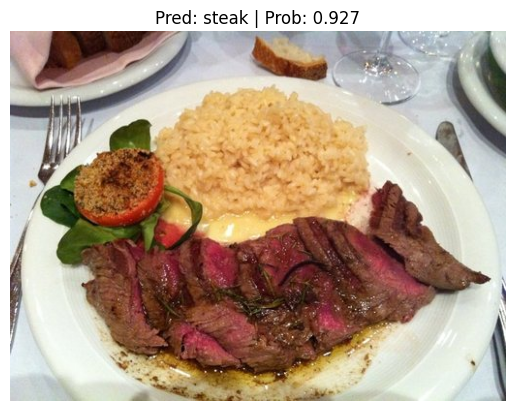

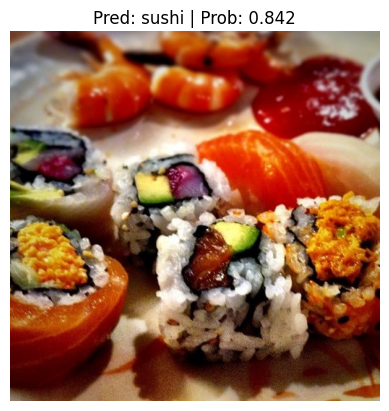

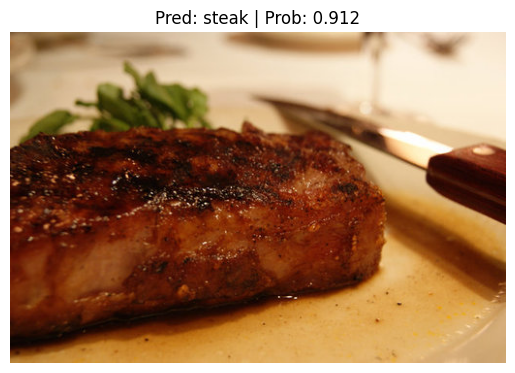

In [53]:
# Import function to make prediction on image and plot them
from src import predictions

# Get a random list of 3 image path names from the test dataset
import random 

num_images_to_plot = 3
test_image_path_list = list(Path("data/pizza_steak_sushi_20/test").glob("*/*jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
    predictions.pred_and_plot_image(
        model=best_model,
        class_names=class_names,
        image_path=image_path,
        image_size=(224, 224)
    )

### 8.1 Predicton on a custom image

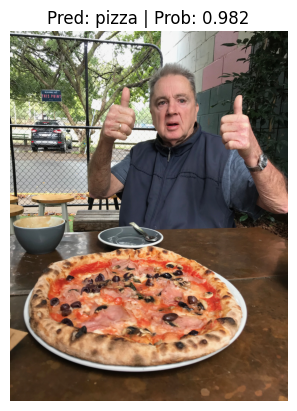

In [54]:
predictions.pred_and_plot_image(
    model=best_model,
    class_names=class_names,
    image_path="pizza-dad.jpeg",
    image_size=(224, 224)
)